In [2]:
# this is the project 

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from scipy import sparse
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

In [3]:
#part I: Explore the data set
train = pd.read_csv('train.csv',index_col= 0, low_memory= False)
test = pd.read_csv('test.csv',index_col= 0, low_memory= False)
train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [4]:
#check the number of the train dataset
len(train)

58645

In [5]:

#explore the features
print(train.columns)
len(train.columns)

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_status'],
      dtype='object')


12

In [6]:
#check the none value
train.isna().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

(array([50295.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  8350.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

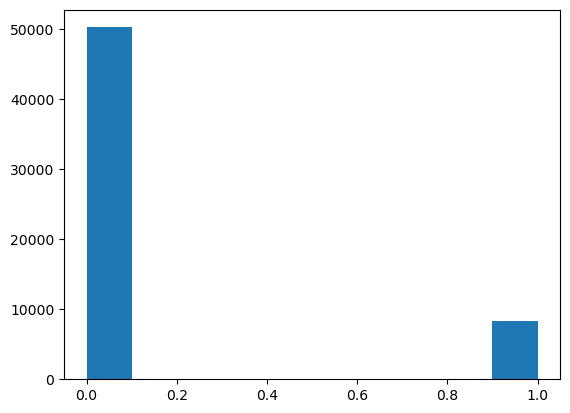

In [7]:
#explore the target(loan approval),loan_status = 0 means 
plt.hist(data = train, x ='loan_status')

In [8]:
# Check how many applicants can get loan approval in the training data
loan_approval_test = train.groupby('loan_status').size()
la_percent_test = loan_approval_test.to_frame(name='number_of_loan').reset_index()

# Calculate total approved and not approved loans
total_test = la_percent_test.number_of_loan.sum()

# Calculate the percentage for each loan status
la_percent_test['Percentage'] = la_percent_test['number_of_loan'] / total_test * 100

print(la_percent_test)

   loan_status  number_of_loan  Percentage
0            0           50295   85.761787
1            1            8350   14.238213


In [9]:
# Ensure `id` is a column in both train and test DataFrames
train = train.reset_index() if 'id' not in train.columns else train
test = test.reset_index() if 'id' not in test.columns else test

In [10]:
# Separate features and target variable in the training set
X = train.drop(['loan_status', 'id'], axis=1, errors='ignore')
y = train['loan_status']
X_test = test.drop(['id'], axis=1, errors='ignore')

In [11]:
# Identify numerical and categorical columns
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

In [12]:
# Preprocessing pipeline
numerical_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [13]:
# Create a pipeline with the preprocessor and the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [14]:
# Split data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object'))])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [16]:
# Validate the model (evaluate with AUC-ROC)
y_val_pred_proba = model.predict_proba(X_val)[:, 1]  # Get the probability of the positive class
auc_score = roc_auc_score(y_val, y_val_pred_proba)
print("Validation AUC-ROC Score:", auc_score)


Validation AUC-ROC Score: 0.9372392584031713


In [17]:
# Train on full training data and predict on the test set
model.fit(X, y)
y_test_pred = model.predict(X_test)

In [18]:
# Prepare the submission file
submission = pd.DataFrame({
    'id': test['id'],
    'loan_status': y_test_pred
})
submission.to_csv('submission.csv', index=False)
print("Submission file created successfully.")

Submission file created successfully.


In [19]:
# Check how many applicants can get loan approval in the test data
loan_approval_test = submission.groupby('loan_status').size()
la_percent_test = loan_approval_test.to_frame(name='number_of_loan').reset_index()

# Calculate total approved and not approved loans
total_test = la_percent_test.number_of_loan.sum()

# Calculate the percentage for each loan status
la_percent_test['Percentage'] = la_percent_test['number_of_loan'] / total_test * 100

print(la_percent_test)

   loan_status  number_of_loan  Percentage
0            0           34932   89.344724
1            1            4166   10.655276
